# Point to point low-thrust transfer

In this tutorial we show the use of the {class}`pykep.trajopt.direct_point2point` to find a low-thrust trajectory connecting two fixed points in space. 
Since the points are considered fixed this effort has mainly an academic value, but it is infomrative in the study of the numerical properties of an optimization pipeline. 
The decision vector in this class compatible with {cite:p}`pagmo` UDPs (User Defined Problems) is:

$$
\mathbf x = [m_f, u_{x0}, u_{y0}, u_{z0}, u_{x1}, u_{y1}, u_{z1}, ..., T_{tof}]
$$

:::{note}
This notebook makes use of the commercial solver SNOPT 7 and to run needs a valid `snopt_7_c` library installed in the system. In case SNOPT7 is not available, you can still run the notebook using, for example `uda = pg.algorithm.nlopt("slsqp")` with minor modifications.

Basic imports:

In [3]:
import pykep as pk
import numpy as np
import time
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
import time

from matplotlib import pyplot as plt

In [4]:
# Problem data
mu = pk.MU_SUN
max_thrust = 0.12
isp = 3000

# Initial state
ms = 1500.0
rs = np.array([1.2, 0.0, -0.01]) * pk.AU
vs = np.array([0.01, 1, -0.01]) * pk.EARTH_VELOCITY

# Final state
mf = 1300.0
rf = np.array([1, 0.0, -0.0]) * pk.AU
vf = np.array([0.01, 1.1, -0.0]) * pk.EARTH_VELOCITY

# Throttles and tof
nseg = 4
throttles = np.random.uniform(-1, 1, size=(nseg * 3))
tof = 2 * np.pi * np.sqrt(pk.AU**3 / pk.MU_SUN) / 4

udp_nog = pk.trajopt.direct_point2point(
    rvs=[rs, vs],
    rvf=[rf, vf],
    mu=pk.MU_SUN,
    max_thrust=0.22,
    isp=3000,
    tof_bounds=[200, 500],
    mf_bounds=[200.0, 1000.0],
    nseg=nseg,
    cut=0.6,
    with_gradient=False,
)

udp_g = pk.trajopt.direct_point2point(
    rvs=[rs, vs],
    rvf=[rf, vf],
    mu=pk.MU_SUN,
    max_thrust=0.22,
    isp=3000,
    tof_bounds=[200, 500],
    mf_bounds=[200.0, 1000.0],
    nseg=nseg,
    cut=0.6,
    with_gradient=True,
)

In [9]:
snopt72 = "/usr/local/lib/libsnopt7_c.so"
uda = ppnf.snopt7(library=snopt72, minor_version=2, screen_output=False)
uda.set_integer_option("Major iterations limit", 2000)
uda.set_integer_option("Iterations limit", 20000)
uda.set_numeric_option("Major optimality tolerance", 1e-3)
uda.set_numeric_option("Major feasibility tolerance", 1e-12)

# uda = pg.nlopt("slsqp")
algo = pg.algorithm(uda)

In [10]:
prob_nog = pg.problem(udp_nog)
prob_nog.c_tol = 1e-6
prob_g = pg.problem(udp_g)
prob_g.c_tol = 1e-6
pop_g = pg.population(prob_g, 1)
pop_g = algo.evolve(pop_g)
print(prob_g.feasibility_f(pop_g.champion_f))

True


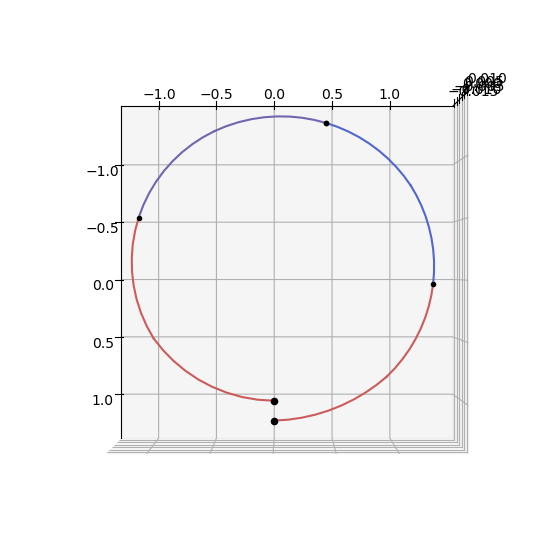

In [11]:
ax = udp_nog.plot(pop_g.get_x()[0], show_gridpoints=True)
ax.view_init(90, 0)

In [2]:
from tqdm import tqdm

cpu_nog = []
cpu_g = []

fail_g = 0
fail_nog = 0

for i in tqdm(range(2000)):
    pop_nog = pg.population(prob_nog, 1)

    pop_g = pg.population(prob_g)
    pop_g.push_back(pop_nog.get_x()[0])

    start = time.time()
    pop_g = algo.evolve(pop_g)
    end = time.time()
    cpu_g.append(end - start)
    if not prob_g.feasibility_f(pop_g.champion_f):
        fail_g += 1

    start = time.time()
    pop_nog = algo.evolve(pop_nog)
    end = time.time()
    cpu_nog.append(end - start)
    if not prob_nog.feasibility_f(pop_nog.champion_f):
        fail_nog += 1

print(f"Gradient: {np.median(cpu_g):.4e}s")
print(f"No Gradient: {np.median(cpu_nog):.4e}s")

print(f"\nGradient (n.fails): {fail_g}")
print(f"No Gradient (n.fails): {fail_nog}")

  0%|          | 0/2000 [00:00<?, ?it/s]


NameError: name 'pg' is not defined

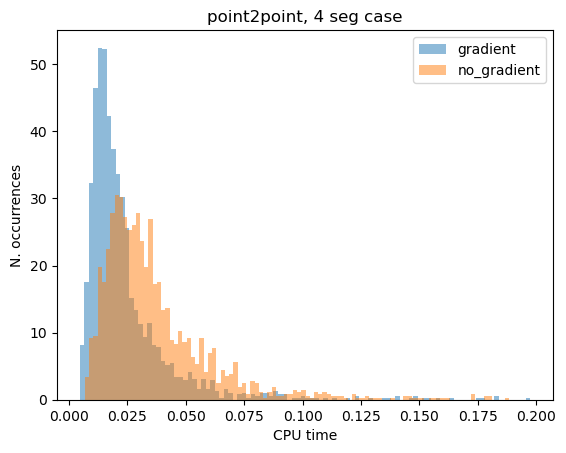

In [30]:
cpu_g = np.array(cpu_g)
cpu_nog = np.array(cpu_nog)
plt.hist(cpu_g[cpu_g < 0.2], bins=100, label="gradient", density=True, alpha=0.5)
plt.hist(cpu_nog[cpu_nog < 0.2], bins=100, label="no_gradient", density=True, alpha=0.5)
# plt.xlim([0,0.15])
plt.legend()
plt.title("point2point, 4 seg case")
plt.xlabel("CPU time")
plt.ylabel("N. occurrences")

In [12]:
udp_g.leg.tof=1232.
udp_g.leg

Number of segments: 4
Number of fwd segments: 2
Number of bck segments: 2
Maximum thrust: 0.22
Central body gravitational parameter: 1.32712440018e+20
Specific impulse: 3000

Time of flight: 1232
Initial mass: 1000
Final mass: 1
State at departure: [[179517444840, 0, -1495978707], [297.8469183169681, 29784.691831696804, -297.8469183169681]]
State at arrival: [[149597870700, 0, -0], [297.8469183169681, 32763.161014866488, -0]]
Throttles values: [-0.5531180194281187, 0.14971757884060444, 0.7940199350920427, 0.028288032565428445, -0.11046018798817858, -0.800424150704127, -0.6581747271243201, -0.5884590126432687, 0.9303693454363375, -0.7082653660632694, 0.3855806880092745, 0.3899050835184499]

Mismatch constraints: [29919970440.50476, 38523538.099015325, -1496184052.1450462, -98.7230576541013, -2992.131264375472, -208.49434302739866, 998.99085894998]
Throttle constraints: [-0.04117744584645111, -0.34631951305277053, 0.6450650999139032, -0.19766173011602817]
